# Classification of Poker Hand using Machine Learning methods

### The aim of this project is to build a ML classifier that can predict the strength of a given poker hand based on its cards, classifying it into predefined categories (Poker Hand Types).

### Imports, settings

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

### Dataset: Cattral, R. & Oppacher, F. (2002). Poker Hand [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5KW38.

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data"
columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Label']
df = pd.read_csv(url, names=columns)
df.sample(n=5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Label
9781,2,12,2,1,1,12,3,9,1,10,1
354,3,4,1,10,3,6,3,9,2,3,0
15909,3,3,1,3,2,13,4,1,2,4,1
4612,3,2,1,3,4,13,3,3,3,1,1
1467,1,8,3,13,2,10,3,2,3,6,0


### How to interpret the dataset?

Each record represents a **poker hand** consisting of five playing cards drawn from a standard 52-card deck.  
Each card is described using **two attributes** — `S` for **suit** and `C` for **rank** — resulting in 10 predictive features (`S1–S5`, `C1–C5`).  
The `Label` column indicates the **type of poker hand** (e.g., Pair, Two Pairs, Straight, Flush, etc.), encoded as a number from 0 to 9.

- **S1–S5 (suits):**  
  - 1 = Hearts  
  - 2 = Spades  
  - 3 = Diamonds  
  - 4 = Clubs  

- **C1–C5 (ranks):**  
  - 1–13, where:
    - 1 = Ace
    - 11 = Jack  
    - 12 = Queen  
    - 13 = King

This structure allows us to treat the problem as a **multi-class classification task**, where the model must predict the type of poker hand based on the cards drawn.
#### Let's break down an example to clarify.

In [8]:
df.sample(n=1)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Label
16274,3,13,1,2,3,4,2,6,2,2,1



### In this example of poker hand with id=1110:

- **S1 = 3, C1 = 5**: The first card is of **Clubs** (suit 3) and has a **rank of 5**.
- **S2 = 2, C2 = 13**: The second card is of **Diamonds** (suit 2) and has a **rank of King (13)**.
- **S3 = 4, C3 = 12**: The third card is of **Spades** (suit 4) and has a **rank of Queen (12)**.
- **S4 = 1, C4 = 13**: The fourth card is of **Hearts** (suit 1) and has a **rank of King (13)**.
- **S5 = 1, C5 = 1**: The fifth card is of **Hearts** (suit 1) and has a **rank of Ace (1)**.

And **Label = 1** corresponds to be a **One Pair** poker hand, the second lowest possible. Specifically, the pair is made up of two **Kings** (C2, C4)

List of possible Labels:
- 0: Nothing in hand; not a recognized poker hand 
- 1: One pair; one pair of equal ranks within five cards
- 2: Two pairs; two pairs of equal ranks within five cards
- 3: Three of a kind; three equal ranks within five cards
- 4: Straight; five cards, sequentially ranked with no gaps
- 5: Flush; five cards with the same suit
- 6: Full house; pair + different rank three of a kind
- 7: Four of a kind; four equal ranks within five cards
- 8: Straight flush; straight + flush
- 9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

### Let's check the distribution of cards and labels in dataset.

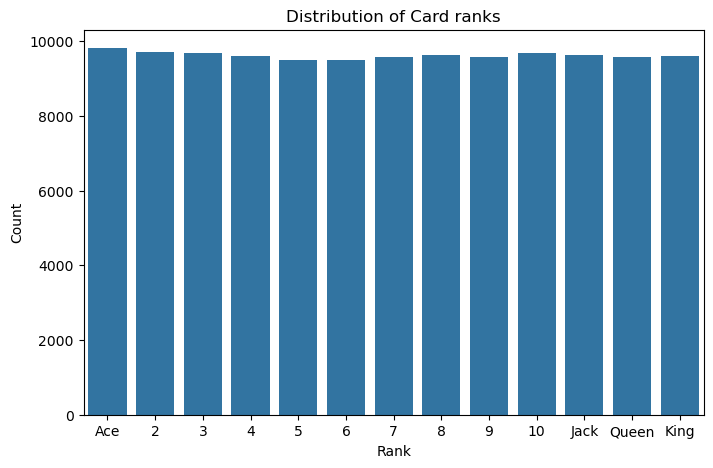

In [11]:
rank_cols = ['C1', 'C2', 'C3', 'C4', 'C5']


ranks = pd.concat([df[col] for col in rank_cols])

plt.figure(figsize=(8,5))
ax = sns.countplot(x=ranks)
plt.title('Distribution of Card ranks')
plt.xlabel('Rank')
plt.ylabel('Count')
ticks = range(13)
ax.set_xticks(ticks)
ax.set_xticklabels( ('Ace', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King') )
plt.show()

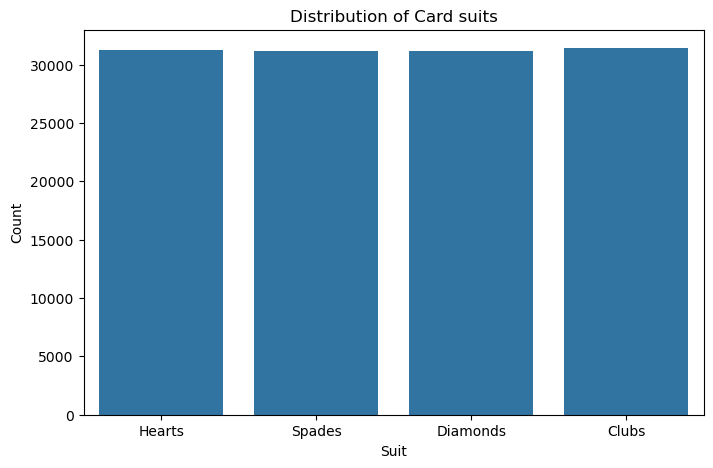

In [12]:
suit_cols = ['S1',  'S2', 'S3', 'S4', 'S5']

suits = pd.concat([df[col] for col in suit_cols])
plt.figure(figsize=(8,5))
ax = sns.countplot(x=suits)
plt.title('Distribution of Card suits')
plt.xlabel('Suit')
plt.ylabel('Count')
ticks = range(4)
ax.set_xticks(ticks)
ax.set_xticklabels( ('Hearts', 'Spades', 'Diamonds', 'Clubs') )
plt.show()

### Distribution of Poker Hand Types

In [14]:
label_mapping = {
    0: 'High Card',
    1: 'One Pair',
    2: 'Two Pair',
    3: 'Three of a Kind',
    4: 'Straight',
    5: 'Flush',
    6: 'Full House',
    7: 'Four of a Kind',
    8: 'Straight Flush',
    9: 'Royal Flush'
}
label_counts = df['Label'].value_counts()

label_counts.index = label_counts.index.map(label_mapping)

print(label_counts)

Label
High Card          12493
One Pair           10599
Two Pair            1206
Three of a Kind      513
Straight              93
Flush                 54
Full House            36
Four of a Kind         6
Royal Flush            5
Straight Flush         5
Name: count, dtype: int64


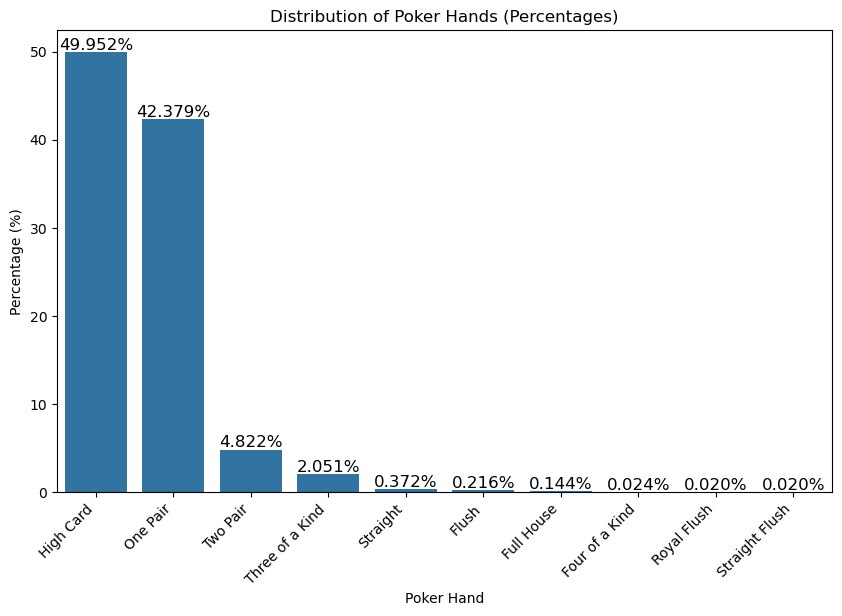

In [15]:
label_percentages = label_counts / label_counts.sum() * 100

plt.figure(figsize=(10,6))
ax = sns.barplot(x=label_percentages.index, y=label_percentages.values)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Poker Hands (Percentages)')
plt.xlabel('Poker Hand')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [16]:
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data"
columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Label']

train = pd.read_csv(train_url, names=columns)
test = pd.read_csv(test_url, names=columns)

print(train.shape, test.shape)

(25010, 11) (1000000, 11)


### Extract Features

In [18]:
X_train = train.drop('Label', axis=1)
y_train = train['Label']

X_test = test.drop('Label', axis=1)
y_test = test['Label']

### Baseline: Logistic Regression

In [35]:
class PokerFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ranks = X[['C1', 'C2', 'C3', 'C4', 'C5']].to_numpy(dtype=int)
        suits = X[['S1', 'S2', 'S3', 'S4', 'S5']].to_numpy(dtype=int)

        # 1. max count of cards of the same value (bincount, we do it in loop for speed)
        max_rank_count = np.max([np.bincount(row, minlength=15) for row in ranks], axis=1)

        # 2. flush: all suits same
        is_flush = (suits == suits[:, [0]]).all(axis=1).astype(int)

        # 3. straight: 5 unique, consecutive
        sorted_ranks = np.sort(ranks, axis=1)
        is_straight = ((sorted_ranks[:, -1] - sorted_ranks[:, 0] == 4) &
                       (np.count_nonzero(np.diff(sorted_ranks, axis=1), axis=1) == 4)).astype(int)

        # 4. number of unique ranks
        unique_ranks = np.array([len(set(row)) for row in ranks])

        # 5. sum of ranks
        sum_ranks = ranks.sum(axis=1)

        return np.column_stack((max_rank_count, is_flush, is_straight, unique_ranks, sum_ranks))

preprocessor = ColumnTransformer(
    transformers=[
        ('poker_features', PokerFeatureExtractor(), 
         ['C1', 'C2', 'C3', 'C4', 'C5', 'S1', 'S2', 'S3', 'S4', 'S5'])
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

clf = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', C=1.0)
clf.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [37]:
y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.977773
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    501209
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       0.15      1.00      0.26      3885
           5       1.00      0.95      0.97      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       1.00      1.00      1.00        12
           9       0.03      1.00      0.05         3

    accuracy                           0.98   1000000
   macro avg       0.82      0.99      0.83   1000000
weighted avg       1.00      0.98      0.99   1000000

Confusion Matrix:
[[479090      0      0      0  22119      0      0      0      0      0]
 [     0 422498      0      0      0      0      0      0      0      0]
 [     0      0  47622      0      

### With getting such high accuracy with only logistic regression I got scared that there is some data leak, but it appends that it's a mix of coincidences:
 - Features as **is_flush**, **is_straight** and **max_rank_count** maps directly into correct Poker Hands, so the model acts more like a rule-based classifier rather than a traditional statistical learner.
 - The model's performance is misleading for minority classes like **Straight** or **Royal Flush**, because those don't have straight rules leading to them.
 - There is a very decent **class imbalance**, as over 99% of the data belongs to majority classes (High card, One Pair). That leads to poor generalization for poker hands.
 - As the minority poker hands are minor, accuracy is dominated by classes that are easier to classify.

### How can I handle this problem?
 - Enhance feature engineering: Add more domain-specific features for rarer cases, like *is_royal* to detect Ace-King-Queen-Jack-10 sequences.
 - Use some techniques 